## Loading data

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'THESIS data part 6.xlsx'

all_sheets = pd.read_excel(file_path, sheet_name=None)
process_scores = all_sheets['Process_scores']

# Process scores over all participants
process_scores_filtered = process_scores.iloc[:, 2:-1]
process_scores_per_idea = process_scores_filtered / 3
total_participants = process_scores_filtered.shape[0]

display(process_scores_filtered.describe().T)
display(process_scores_per_idea.describe().T.round(2))

C:\Users\kimva\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\kimva\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


,count,mean,std,min,25%,50%,75%,max
Retrieval or recall of prior knowledge or experience,25.0,6.04,5.167849,0.0,2.0,5.0,10.0,23.0
Performing mental operations on the stimulus,25.0,1.56,1.293574,0.0,0.0,2.0,2.0,4.0
Creating an imaginary scene,25.0,7.52,3.720663,1.0,5.0,7.0,10.0,15.0
Mentioning stimulus properties,25.0,24.44,3.014963,18.0,23.0,24.0,27.0,30.0
Imagining stimulus properties,25.0,2.80,2.254625,0.0,1.0,3.0,4.0,9.0


,count,mean,std,min,25%,50%,75%,max
Retrieval or recall of prior knowledge or experience,25.0,2.01,1.72,0.00,0.67,1.67,3.33,7.67
Performing mental operations on the stimulus,25.0,0.52,0.43,0.00,0.00,0.67,0.67,1.33
Creating an imaginary scene,25.0,2.51,1.24,0.33,1.67,2.33,3.33,5.00
Mentioning stimulus properties,25.0,8.15,1.00,6.00,7.67,8.00,9.00,10.00
Imagining stimulus properties,25.0,0.93,0.75,0.00,0.33,1.00,1.33,3.00


## Originality scores

In [2]:
originality_sum = all_sheets['Controle']

originality_washand = originality_sum.iloc[1, :]

originality_washand = list(originality_sum.iloc[0, 9:-1])

originality_baksteen = list(originality_sum.iloc[13, 9:-9])

originality_lepel = list(originality_sum.iloc[26, 9:])

### Extracting originality scores per object and process scores

In [3]:
# Extract specific sheets "P1" to "P25"
sheet_names = [f"P{i}" for i in range(1, 26)]
sheets_dict = {name: all_sheets[name] for name in sheet_names}

# Clean and filter the sheets
cleaned_sheets = {}
cleaned_washand = {}
cleaned_baksteen = {}
cleaned_lepel = {}
process_washand = {}
process_baksteen = {}
process_lepel = {}
processes = {}
for name, sheet in sheets_dict.items():
    process = sheet.iloc[1:, 2:7]
    
    # Select columns from J onward (assuming the columns are in alphabetic order)
    sheet = sheet.iloc[:, 9:]
    
    process = process.dropna(how='all')
    process = process.fillna(0)
    process_washand[name] = process.iloc[:10].copy()
    process_baksteen[name] = process.iloc[10:20]
    process_lepel[name] = process.iloc[20:30]

    # Remove rows where all selected columns are empty
    sheet = sheet.dropna(how='all')

    cleaned_washand[name] = sheet.iloc[:10, :-1].copy()
    cleaned_baksteen[name] = sheet.iloc[11:21, :-9].copy()
    cleaned_baksteen[name].columns = sheet.iloc[10, :-9].copy()
    cleaned_lepel[name] = sheet.iloc[22:32].copy()
    cleaned_lepel[name].columns = sheet.iloc[21].copy()
    
    # Store the cleaned DataFrame
    cleaned_sheets[name] = sheet
    processes[name] = process

process_washand_participant = pd.concat(process_washand.values(), ignore_index=True)
process_baksteen_participant = pd.concat(process_baksteen.values(), ignore_index=True)
process_lepel_participant = pd.concat(process_lepel.values(), ignore_index=True)

originality_washand_participant = pd.concat(cleaned_washand.values(), ignore_index=True)
originality_baksteen_participant = pd.concat(cleaned_baksteen.values(), ignore_index=True)
originality_lepel_participant = pd.concat(cleaned_lepel.values(), ignore_index=True)

### Originality score per idea

In [4]:
def originality(originality_participant, total_participants):
    originality_scores = originality_participant.copy()

    # Calculate the originality scores for cells with value 1
    for col in originality_participant.columns:
        # Count the number of participants who generated each idea (number of 1s in each column)
        idea_counts = originality_participant[col].value_counts().get(1, 0)

        # Ensure idea_counts does not exceed total_participants
        idea_counts = min(idea_counts, total_participants)

        # Calculate originality score for the column
        originality_score = 1 - (idea_counts / total_participants)

        # Apply the originality score to the cells with value 1
        originality_scores[col] = originality_participant[col].apply(lambda x: originality_score if x == 1 else None)

    # Drop rows where all values are NaN (no originality scores)
    originality_scores.dropna(how='all', inplace=True)
    
    return originality_scores
originality_scores_washand = originality(originality_washand_participant, total_participants).stack().reset_index()
originality_scores_washand.columns = ['Index', 'Idea', 'Originality Score']
# print(originality_scores_washand)

originality_scores_baksteen = originality(originality_baksteen_participant, total_participants).stack().reset_index()
originality_scores_baksteen.columns = ['Index', 'Idea', 'Originality Score']
# print(originality_scores_baksteen)

originality_scores_lepel = originality(originality_lepel_participant, total_participants).stack().reset_index()
originality_scores_lepel.columns = ['Index', 'Idea', 'Originality Score']
# print(originality_scores_lepel)

### Descriptive statistics for washand

In [5]:
# Calculate descriptive statistics for the originality scores
descriptive_stats = originality_scores_washand['Originality Score'].describe()

# Calculate additional statistics
mean_originality = originality_scores_washand['Originality Score'].mean()
median_originality = originality_scores_washand['Originality Score'].median()
std_originality = originality_scores_washand['Originality Score'].std()
min_originality = originality_scores_washand['Originality Score'].min()
max_originality = originality_scores_washand['Originality Score'].max()
count_originality = originality_scores_washand['Originality Score'].count()
iqr_originality = originality_scores_washand['Originality Score'].quantile(0.75) - originality_scores_washand['Originality Score'].quantile(0.25)

# Print the descriptive statistics
print("Descriptive Statistics for Originality Scores:")
print(f"Count: {count_originality}")
print(f"Mean: {mean_originality:.2f}")
print(f"Median: {median_originality:.2f}")
print(f"Standard Deviation: {std_originality:.2f}")
print(f"Minimum: {min_originality:.2f}")
print(f"Maximum: {max_originality:.2f}")
print(f"25th Percentile: {originality_scores_washand['Originality Score'].quantile(0.25):.2f}")
print(f"75th Percentile: {originality_scores_washand['Originality Score'].quantile(0.75):.2f}")
print(f"Interquartile Range (IQR): {iqr_originality:.2f}")

# Display the detailed descriptive statistics
print("\nDetailed Descriptive Statistics:")
display(descriptive_stats)


Descriptive Statistics for Originality Scores:
Count: 250
Mean: 0.40
Median: 0.36
Standard Deviation: 0.37
Minimum: 0.00
Maximum: 0.96
25th Percentile: 0.00
75th Percentile: 0.79
Interquartile Range (IQR): 0.79

Detailed Descriptive Statistics:


count    250.000000
mean       0.404160
std        0.374524
min        0.000000
25%        0.000000
50%        0.360000
75%        0.790000
max        0.960000
Name: Originality Score, dtype: float64

### Descriptive statistics for baksteen

In [6]:
# Calculate descriptive statistics for the originality scores
descriptive_stats = originality_scores_baksteen['Originality Score'].describe()

# Calculate additional statistics
mean_originality = originality_scores_baksteen['Originality Score'].mean()
median_originality = originality_scores_baksteen['Originality Score'].median()
std_originality = originality_scores_baksteen['Originality Score'].std()
min_originality = originality_scores_baksteen['Originality Score'].min()
max_originality = originality_scores_baksteen['Originality Score'].max()
count_originality = originality_scores_baksteen['Originality Score'].count()
iqr_originality = originality_scores_baksteen['Originality Score'].quantile(0.75) - originality_scores_baksteen['Originality Score'].quantile(0.25)

# Print the descriptive statistics
print("Descriptive Statistics for Originality Scores:")
print(f"Count: {count_originality}")
print(f"Mean: {mean_originality:.2f}")
print(f"Median: {median_originality:.2f}")
print(f"Standard Deviation: {std_originality:.2f}")
print(f"Minimum: {min_originality:.2f}")
print(f"Maximum: {max_originality:.2f}")
print(f"25th Percentile: {originality_scores_baksteen['Originality Score'].quantile(0.25):.2f}")
print(f"75th Percentile: {originality_scores_baksteen['Originality Score'].quantile(0.75):.2f}")
print(f"Interquartile Range (IQR): {iqr_originality:.2f}")

# Display the detailed descriptive statistics
print("\nDetailed Descriptive Statistics:")
print(descriptive_stats)

Descriptive Statistics for Originality Scores:
Count: 250
Mean: 0.37
Median: 0.36
Standard Deviation: 0.33
Minimum: 0.00
Maximum: 0.96
25th Percentile: 0.00
75th Percentile: 0.60
Interquartile Range (IQR): 0.60

Detailed Descriptive Statistics:
count    250.000000
mean       0.367040
std        0.327171
min        0.000000
25%        0.000000
50%        0.360000
75%        0.600000
max        0.960000
Name: Originality Score, dtype: float64


### Descriptive statistics for lepel

In [7]:
# Calculate descriptive statistics for the originality scores
descriptive_stats = originality_scores_lepel['Originality Score'].describe()

# Calculate additional statistics
mean_originality = originality_scores_lepel['Originality Score'].mean()
median_originality = originality_scores_lepel['Originality Score'].median()
std_originality = originality_scores_lepel['Originality Score'].std()
min_originality = originality_scores_lepel['Originality Score'].min()
max_originality = originality_scores_lepel['Originality Score'].max()
count_originality = originality_scores_lepel['Originality Score'].count()
iqr_originality = originality_scores_lepel['Originality Score'].quantile(0.75) - originality_scores_lepel['Originality Score'].quantile(0.25)

# Print the descriptive statistics
print("Descriptive Statistics for Originality Scores:")
print(f"Count: {count_originality}")
print(f"Mean: {mean_originality:.2f}")
print(f"Median: {median_originality:.2f}")
print(f"Standard Deviation: {std_originality:.2f}")
print(f"Minimum: {min_originality:.2f}")
print(f"Maximum: {max_originality:.2f}")
print(f"25th Percentile: {originality_scores_lepel['Originality Score'].quantile(0.25):.2f}")
print(f"75th Percentile: {originality_scores_lepel['Originality Score'].quantile(0.75):.2f}")
print(f"Interquartile Range (IQR): {iqr_originality:.2f}")

# Display the detailed descriptive statistics
print("\nDetailed Descriptive Statistics:")
print(descriptive_stats)

Descriptive Statistics for Originality Scores:
Count: 250
Mean: 0.36
Median: 0.00
Standard Deviation: 0.41
Minimum: 0.00
Maximum: 0.96
25th Percentile: 0.00
75th Percentile: 0.76
Interquartile Range (IQR): 0.76

Detailed Descriptive Statistics:
count    250.000000
mean       0.360320
std        0.408331
min        0.000000
25%        0.000000
50%        0.000000
75%        0.760000
max        0.960000
Name: Originality Score, dtype: float64


### Averaged scores per object

In [8]:
# Initialize a new dataframe to store the averaged scores
num_rows, num_cols = originality_scores_washand.shape
num_chunks = num_rows // 10
averaged_scores_washand = pd.DataFrame()

# Iterate over each chunk of 10 rows
for i in range(num_chunks):
    start_idx = i * 10
    end_idx = start_idx + 10
    
    # Compute the mean for the chunk
    chunk_mean = originality_scores_washand['Originality Score'].iloc[start_idx:end_idx].mean()
    
    # Convert the mean to a DataFrame and append to the new dataframe
    averaged_scores_washand = pd.concat([averaged_scores_washand, pd.DataFrame({'Originality Score': [chunk_mean]})], ignore_index=True)

# # Print the resulting dataframe
# print("Averaged Originality Scores DataFrame:")
# print(averaged_scores_washand)

# # Check descriptive statistics of the averaged scores
# print("\nDescriptive Statistics of Averaged Scores:")
# print(averaged_scores_washand.describe())

# Initialize a new dataframe to store the averaged scores
num_rows, num_cols = originality_scores_baksteen.shape
num_chunks = num_rows // 10
averaged_scores_baksteen = pd.DataFrame()

# Iterate over each chunk of 10 rows
for i in range(num_chunks):
    start_idx = i * 10
    end_idx = start_idx + 10
    
    # Compute the mean for the chunk
    chunk_mean = originality_scores_baksteen['Originality Score'].iloc[start_idx:end_idx].mean()
    
    # Convert the mean to a DataFrame and append to the new dataframe
    averaged_scores_baksteen = pd.concat([averaged_scores_baksteen, pd.DataFrame({'Originality Score': [chunk_mean]})], ignore_index=True)

# # Print the resulting dataframe
# print("Averaged Originality Scores DataFrame:")
# print(averaged_scores_baksteen)

# # Check descriptive statistics of the averaged scores
# print("\nDescriptive Statistics of Averaged Scores:")
# print(averaged_scores_baksteen.describe())

# Initialize a new dataframe to store the averaged scores
num_rows, num_cols = originality_scores_lepel.shape
num_chunks = num_rows // 10
averaged_scores_lepel = pd.DataFrame()

# Iterate over each chunk of 10 rows
for i in range(num_chunks):
    start_idx = i * 10
    end_idx = start_idx + 10
    
    # Compute the mean for the chunk
    chunk_mean = originality_scores_lepel['Originality Score'].iloc[start_idx:end_idx].mean()
    
    # Convert the mean to a DataFrame and append to the new dataframe
    averaged_scores_lepel = pd.concat([averaged_scores_lepel, pd.DataFrame({'Originality Score': [chunk_mean]})], ignore_index=True)

# # Print the resulting dataframe
# print("Averaged Originality Scores DataFrame:")
# print(averaged_scores_lepel)

# # Check descriptive statistics of the averaged scores
# print("\nDescriptive Statistics of Averaged Scores:")
# print(averaged_scores_lepel.describe())

### Combining the averaged scores to get the originality scores

In [9]:
# Averaged the scores of the objects over all participants
# Dividing the combined by 3 to get the average of the total sessions
combined_originality_scores = (averaged_scores_washand + averaged_scores_baksteen + averaged_scores_lepel) / 3
corr = pd.concat([combined_originality_scores, process_scores_filtered], axis=1).corr()

table = pd.concat([combined_originality_scores, process_scores_per_idea], axis = 1).describe().T.round(2)

# table.to_excel("Descriptive Statistics.xlsx")
# corr.to_excel("Correlation Matrix.xlsx")

print("Descriptive statistics")
display(table)

print("Correlation Matrix:")
display(corr)

Descriptive statistics


,count,mean,std,min,25%,50%,75%,max
Originality Score,25.0,0.38,0.11,0.18,0.29,0.37,0.46,0.57
Retrieval or recall of prior knowledge or experience,25.0,2.01,1.72,0.00,0.67,1.67,3.33,7.67
Performing mental operations on the stimulus,25.0,0.52,0.43,0.00,0.00,0.67,0.67,1.33
Creating an imaginary scene,25.0,2.51,1.24,0.33,1.67,2.33,3.33,5.00
Mentioning stimulus properties,25.0,8.15,1.00,6.00,7.67,8.00,9.00,10.00
Imagining stimulus properties,25.0,0.93,0.75,0.00,0.33,1.00,1.33,3.00


Correlation Matrix:


,Originality Score,Retrieval or recall of prior knowledge or experience,Performing mental operations on the stimulus,Creating an imaginary scene,Mentioning stimulus properties,Imagining stimulus properties
Originality Score,1.000000,0.121956,0.277170,-0.254192,0.256151,-0.336875
Retrieval or recall of prior knowledge or experience,0.121956,1.000000,0.090003,-0.308841,-0.003851,-0.217424
Performing mental operations on the stimulus,0.277170,0.090003,1.000000,-0.028396,-0.065811,-0.102862
Creating an imaginary scene,-0.254192,-0.308841,-0.028396,1.000000,-0.299825,0.017881
Mentioning stimulus properties,0.256151,-0.003851,-0.065811,-0.299825,1.000000,-0.666901
Imagining stimulus properties,-0.336875,-0.217424,-0.102862,0.017881,-0.666901,1.000000


## Ranks

In [10]:
# Combining the process scores of the different objects
combined_data = pd.concat([process_washand_participant, process_baksteen_participant, process_lepel_participant], ignore_index=True)

# Initialize a dictionary to hold the counts for each DT process
dt_processes = ['Retrieval or recall of prior knowledge or experience', 
                'Performing mental operations on the stimulus', 
                'Creating an imaginary scene', 
                'Mentioning stimulus properties',
                'Imagining stimulus properties', 
                ]

# Create an empty DataFrame to hold the results
result_table = pd.DataFrame(index=range(1, 11), columns=dt_processes)

# Fill the result table with counts of each process at each rank
for process in dt_processes:
    for rank in range(1, 11):
        result_table.at[rank, process] = (combined_data[process].iloc[rank-1::10] == 1).sum()

# Calculate the total number of uses for each process
result_table.loc['N(use)'] = result_table.sum()

result_table['N(use)'] = 75

# Calculate N(participant) for each process
n_participants = {}
for process in result_table.columns:
    if process == 'N(use)':
        n_participants[process] = total_participants
    else:
        n_participants[process] = (process_scores_per_idea[process] > 0).sum()
    
result_table.loc['N(session)'] = pd.Series(n_participants)

result_table.index.name = 'Use rank'

# Reorder columns as required
result_table = result_table[['N(use)'] + dt_processes]

# result_table.to_excel("Use ranks.xlsx")

# Print the final summary table
display(result_table)

,N(use),Retrieval or recall of prior knowledge or experience,Performing mental operations on the stimulus,Creating an imaginary scene,Mentioning stimulus properties,Imagining stimulus properties
Use rank,,,,,,
1,75,25,0,12,53,3
2,75,19,6,15,63,6
3,75,14,5,15,57,10
4,75,14,3,19,61,6
5,75,12,1,18,68,6
6,75,14,4,19,62,9
7,75,18,7,16,59,8
8,75,12,6,25,62,6
9,75,10,3,27,64,7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Originality Score   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.8910
Date:                Fri, 21 Jun 2024   Prob (F-statistic):              0.513
Time:                        18:18:45   Log-Likelihood:                 20.264
No. Observations:                  20   AIC:                            -28.53
Df Residuals:                      14   BIC:                            -22.55
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.4438      0.391      1.135      0.275      -0.395       1.282
Retrieval or recall of prior knowledge or experience    -0.0045      0.017     -0.263      0.796      -0.041       0.032
Performing mental operations on the stimulus             0.0536      0.057      0.936      0.365      -0.069       0.176
Creating an imaginary scene                             -0.0289      0.022     -1.338      0.202      -0.075       0.017
Mentioning stimulus properties                           0.0044      0.038      0.117      0.908      -0.076       0.085
Imagining stimulus properties                           -0.0391      0.058     -0.679      0.508      -0.163       0.084
==============================================================================
Omnibus:                        1.493   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.124
Skew:                          -0.555   Prob(JB):                        0.570
Kurtosis:                       2.660   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

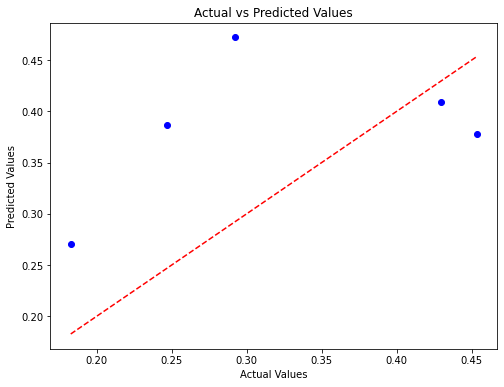

In [11]:
# Splitting the data into train and test sets
X = process_scores_per_idea  # Feature
y = combined_originality_scores  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adding a constant term for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fitting the model using statsmodels
model = sm.OLS(y_train, X_train_sm).fit()

# Printing the model summary
summary = model.summary()
display(summary)

# Making predictions with statsmodels
X_test_sm = sm.add_constant(X_test)
y_pred_sm = model.predict(X_test_sm)

# Visualizing the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_sm, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [13]:
# Extracting coefficients and related information
second_table = summary.tables[1]  # Get the second table from the summary (indexing starts from 0)

# Extracting coefficients and standard errors
coefficients = np.array(second_table.data[1:])[:, 1].astype(float)  # Extracting coefficients (column 1)
std_errors = np.array(second_table.data[1:])[:, 2].astype(float)    # Extracting standard errors (column 2)

# Extracting t-values and p-values
t_values = np.array(second_table.data[1:])[:, 3].astype(float)      # Extracting t-values (column 3)
p_values = np.array(second_table.data[1:])[:, 4].astype(float)      # Extracting p-values (column 4)

# Extracting confidence intervals
confidence_intervals = np.array(second_table.data[1:])[:, 5:7].astype(float)  # Extracting confidence intervals (columns 5 and 6)

r_squared = float(summary.tables[0].data[0][3])

# Predictor names (excluding the constant)
predictors = [
    'Retrieval or recall of prior knowledge or experience',
    'Performing mental operations on the stimulus',
    'Creating an imaginary scene',
    'Mentioning stimulus properties',
    'Imagining stimulus properties'
]

# Prepare data for the table
table_data = []

table_data.append(["", f"{r_squared:.3f}", "", "", "", "", ""])

# Column names
column_names = ['Predictor', 'R²', 'B', 'SE B', 't', 'P > |t|', '[0.025 0.975]']

# Iterate over the predictors and populate the table data
for i, predictor in enumerate(predictors):
    B_value = coefficients[i]
    SE_B_value = std_errors[i]
    t_value = t_values[i]
    p_value = p_values[i]
    lower_bound, upper_bound = confidence_intervals[i]

    # Format the values
    B_value_formatted = f"{B_value:.3f}"
    SE_B_value_formatted = f"{SE_B_value:.3f}"
    t_value_formatted = f"{t_value:.3f}"
    p_value_formatted = f"{p_value:.3f}"
    confidence_interval_formatted = f"[{lower_bound:.3f} {upper_bound:.3f}]"

    # Append row to table data
    table_data.append([predictor, "", B_value_formatted, SE_B_value_formatted, t_value_formatted, p_value_formatted, confidence_interval_formatted])

# Display the table
display(pd.DataFrame(table_data, columns=column_names))

,Predictor,R²,B,SE B,t,P > |t|,[0.025 0.975]
0,,0.241,,,,,
1,Retrieval or recall of prior knowledge or expe...,,0.444,0.391,1.135,0.275,[-0.395 1.282]
2,Performing mental operations on the stimulus,,-0.004,0.017,-0.263,0.796,[-0.041 0.032]
3,Creating an imaginary scene,,0.054,0.057,0.936,0.365,[-0.069 0.176]
4,Mentioning stimulus properties,,-0.029,0.022,-1.338,0.202,[-0.075 0.017]
5,Imagining stimulus properties,,0.004,0.038,0.117,0.908,[-0.076 0.085]
